## Transfer Learning for Computer Vision Tutorial

**Author**: [Sasank Chilamkurthy](https://chsasank.github.io)

**Modified by**: win7 at october 2022

In this tutorial, you will learn how to train a convolutional neural network for
image classification using transfer learning. You can read more about the transfer
learning at [cs231n notes](https://cs231n.github.io/transfer-learning/)_

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initialization, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.


### Imports

In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

import pandas as pd
import shutil
import sys

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from PIL import Image

from tqdm import tqdm
import memory_profiler  # conda install -c anaconda memory_profiler
# cudnn.benchmark = True
# plt.ion()   # interactive mode
import neptune

%matplotlib inline
%load_ext autotime

time: 199 µs (started: 2023-06-30 12:18:56 -05:00)


### Functions



In [2]:
def move_split(df, type): # change this function according your dataset
    if not os.path.isdir("dataset"):
        os.makedirs("dataset")

        for item in np.unique(df.iloc[:, -1]):
            os.makedirs("dataset/train/class_{}".format(item))
            os.makedirs("dataset/valid/class_{}".format(item))
    
    for index, row in tqdm(df.iterrows()):
        s = "source/train/{}_{}.jpg".format(row["ID"], row["location"])
        t = "dataset/{}/class_{}".format(type, row["level"])
        shutil.copy(s, t)

def set_parameter_requires_grad(model, feature_extract):
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False

# set initialize weight for custom model
def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

def classifier_model(num_ftrs, num_classes, init_weight=False):
    # Custom model
    """ torch.nn.Conv2d(in_channels=8, out_channels=3, kernel_size=(3, 3), padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2, 2)),
    torch.nn.Conv2d(in_channels=3, out_channels=2, kernel_size=(3, 3), padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2, 2)),
    torch.nn.Flatten(), """

    model = torch.nn.Sequential(torch.nn.Linear(num_ftrs, 128),
                                torch.nn.ReLU(),

                                torch.nn.Linear(128, 64),
                                torch.nn.ReLU(),
                                torch.nn.Dropout(0.5),

                                torch.nn.Linear(64, num_classes))
    if init_weight:
        model.apply(init_weights)
    return model

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    # variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet50":
        weights = models.ResNet50_Weights.IMAGENET1K_V2 # 97.8M
        model_ft = models.resnet50(weights=weights)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = classifier_model(num_ftrs, num_classes, init_weight=True) # nn.Linear(num_ftrs, num_classes)
        input_size = 224

    if model_name == "resnet152":
        weights = models.ResNet152_Weights.IMAGENET1K_V2 # 230M
        model_ft = models.resnet152(weights=weights)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = classifier_model(num_ftrs, num_classes, init_weight=True) # # nn.Linear(num_ftrs, num_classes)
        input_size = 224
    elif model_name == "alexnet":
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = classifier_model(num_ftrs, num_classes, init_weight=True) # nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg19":
        weights = models.VGG19_Weights.IMAGENET1K_V1 # 548M
        model_ft = models.vgg19(weights=weights)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = classifier_model(num_ftrs, num_classes, init_weight=True) # nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet1_0":
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet201":
        weights = models.DenseNet201_Weights.IMAGENET1K_V1 # 77.4M
        model_ft = models.densenet201(weights=weights)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = classifier_model(num_ftrs, num_classes, init_weight=True) # nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        weights = models.Inception_V3_Weights.IMAGENET1K_V1 #
        model_ft = models.inception_v3(weights=weights, progress=True)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalidid model name, exiting...")
        exit()

    return model_ft, input_size

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def train_model(run, model, device, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    valid_acc_history = []

    train_losses = []
    valid_losses = []

    train_accuracies = []
    valid_accuracies = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    loop_obj = tqdm(range(num_epochs))
    for epoch in loop_obj:
        # print(f"Epoch {epoch + 1}/{num_epochs}")
        # print("-" * 10)
        loop_obj.set_description(f"Epoch: {epoch + 1}")

        # Each epoch has a training and valididation phase
        for phase in ["train", "valid"]:
            if phase == "train":
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == "train":
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == "train":
                train_accuracies.append(epoch_acc)
                train_losses.append(epoch_loss)

                run["train/accuracy"].append(epoch_acc)
                run["train/loss"].append(epoch_loss)
            else:
                valid_accuracies.append(epoch_acc)
                valid_losses.append(epoch_loss)

                run["valid/accuracy"].append(epoch_acc)
                run["valid/loss"].append(epoch_loss)

            # print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            loop_obj.set_postfix_str(f"{phase}, Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # deep copy the model
            if phase == "valid" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "valid":
                valid_acc_history.append(epoch_acc)

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best valid Acc: {best_acc:4f}")

    run["runtimel/training"] = time_elapsed

    # load best model weights
    model.load_state_dict(best_model_wts)

    # run.stop()
    return model, train_losses, valid_losses, train_accuracies, valid_accuracies # valid_acc_history

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders["valid"]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis("off")
                ax.set_title(f"predicted: {class_names[preds[j]]}")
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

def show_results(train_losses, valid_losses, train_accuracies, valid_accuracies):
    train_accuracies_ = [h.cpu().numpy() for h in train_accuracies]
    valid_accuracies_ = [h.cpu().numpy() for h in valid_accuracies]

    fig, axes = plt.subplots(1, 2, figsize=(14,4))
    ax1, ax2 = axes
    ax1.plot(train_losses, label="train")
    ax1.plot(valid_losses, label="valid")
    ax1.set_xlabel("Epoch"); ax1.set_ylabel("Loss")
    ax1.grid()
    ax2.plot(train_accuracies_, label="train")
    ax2.plot(valid_accuracies_, label="valid")
    ax2.set_xlabel("Epoch"); ax2.set_ylabel("Accuracy")
    ax2.grid()
    for ax in axes: ax.legend()

def get_predictions(model_ft, dataloaders, data):
    labels = []
    predictions = []
    predictions_proba = []

    with torch.no_grad():
        for batch_x_test, batch_y_test in dataloaders[data]:
            batch_x_test = batch_x_test.to(device).to(torch.float32)
            batch_y_test = batch_y_test.to(device).to(torch.int64)

            batch_test_predictions = model_ft(batch_x_test)
            # batch_test_predictions = model_conv(batch_x_test)

            batch_test_predictions = torch.nn.functional.softmax(batch_test_predictions, dim=-1)
            predictions_proba.append(batch_test_predictions)
            # print(batch_test_predictions)

            batch_test_predictions = batch_test_predictions.max(dim=1).indices
            # print(batch_test_predictions)

            labels.append(batch_y_test)
            predictions.append(batch_test_predictions)

    labels = torch.cat(labels, dim=0)
    predictions = torch.cat(predictions, dim=0)
    predictions_proba = torch.cat(predictions_proba, dim=0)

    labels = labels.cpu().numpy()
    predictions = predictions.cpu().numpy()
    predictions_proba = predictions_proba.cpu().numpy()
    return labels, predictions, predictions_proba

time: 5.67 ms (started: 2023-06-30 12:18:56 -05:00)


### Split data

In [3]:
df = pd.read_csv("source/train.csv")
df

,ID,location,level
0,d3d9446802a44259755d38e6d163e820,left,0
1,d3d9446802a44259755d38e6d163e820,right,0
2,c51ce410c124a10e0db5e4b97fc2af39,left,0
3,c51ce410c124a10e0db5e4b97fc2af39,right,0
4,9bf31c7ff062936a96d3c8bd1f8f2ff3,left,1
...,...,...,...
24583,7dc5ece165388748790d8170245197ed,right,0
24584,e3c216d521607da146fa23d65cfcc6b6,left,0
24585,e3c216d521607da146fa23d65cfcc6b6,right,0
24586,54d9ee4df2caa006b994d148f23a9b10,left,0


time: 46.7 ms (started: 2023-06-30 12:18:56 -05:00)


In [4]:
# count classes
df["level"].value_counts()

0    18057
1     6531
Name: level, dtype: int64

time: 5.59 ms (started: 2023-06-30 12:18:56 -05:00)


In [5]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
len(df_train), len(df_test)

(19670, 4918)

time: 10.8 ms (started: 2023-06-30 12:18:56 -05:00)


In [6]:
# move image into train and test folder
# move_split(df_train, "train")
# move_split(df_test, "valid")

time: 396 µs (started: 2023-06-30 12:18:56 -05:00)


### Parameters

In [7]:
# Top level data directory. Here we assume the format of the directory conforms
# to the ImageFolder structure
data_dir = "dataset"

# Models to choose from [resnet50, resnet152, alexnet, vgg19, squeezenet1_0, densenet201]
model_name = "resnet50"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 20

# Flag for feature extracting. When False, we finetune the whole model,
# when True we only update the reshaped layer params
# feature_extract = True

input_size = 224

time: 933 µs (started: 2023-06-30 12:18:56 -05:00)


### Initialize and Reshape the networks

Set Model Parameters’ .requires_grad attribute
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

This helper function sets the ``.requires_grad`` attribute of the
parameters in the model to False when we are feature extracting. By
default, when we load a pretrained model all of the parameters have
``.requires_grad=True``, which is fine if we are training from scratch
or finetuning. However, if we are feature extracting and only want to
compute gradients for the newly initialized layer then we want all of
the other parameters to not require gradients. This will make more sense
later.




#### Details

Now to the most interesting part. Here is where we handle the reshaping
of each network. Note, this is not an automatic procedure and is unique
to each model. Recall, the final layer of a CNN model, which is often
times an FC layer, has the same number of nodes as the number of output
classes in the dataset. Since all of the models have been pretrained on
Imagenet, they all have output layers of size 1000, one node for each
class. The goal here is to reshape the last layer to have the same
number of inputs as before, AND to have the same number of outputs as
the number of classes in the dataset. In the following sections we will
discuss how to alter the architecture of each model individually. But
first, there is one important detail regarding the difference between
finetuning and feature-extraction.

When feature extracting, we only want to update the parameters of the
last layer, or in other words, we only want to update the parameters for
the layer(s) we are reshaping. Therefore, we do not need to compute the
gradients of the parameters that we are not changing, so for efficiency
we set the .requires_grad attribute to False. This is important because
by default, this attribute is set to True. Then, when we initialize the
new layer and by default the new parameters have ``.requires_grad=True``
so only the new layer’s parameters will be updated. When we are
finetuning we can leave all of the .required_grad’s set to the default
of True.

Finally, notice that inception_v3 requires the input size to be
(299,299), whereas all of the other models expect (224,224).

Resnet
~~~~~~

Resnet was introduced in the paper `Deep Residual Learning for Image
Recognition <https://arxiv.org/abs/1512.03385>`__. There are several
variants of different sizes, including Resnet18, Resnet34, Resnet50,
Resnet101, and Resnet152, all of which are available from torchvision
models. Here we use Resnet18, as our dataset is small and only has two
classes. When we print the model, we see that the last layer is a fully
connected layer as shown below:

::

   (fc): Linear(in_features=512, out_features=1000, bias=True)

Thus, we must reinitialize ``model.fc`` to be a Linear layer with 512
input features and 2 output features with:

::

   model.fc = nn.Linear(512, num_classes)

Alexnet
~~~~~~~

Alexnet was introduced in the paper `ImageNet Classification with Deep
Convolutional Neural
Networks <https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf>`__
and was the first very successful CNN on the ImageNet dataset. When we
print the model architecture, we see the model output comes from the 6th
layer of the classifier

::

   (classifier): Sequential(
       ...
       (6): Linear(in_features=4096, out_features=1000, bias=True)
    )

To use the model with our dataset we reinitialize this layer as

::

   model.classifier[6] = nn.Linear(4096,num_classes)

VGG
~~~

VGG was introduced in the paper `Very Deep Convolutional Networks for
Large-Scale Image Recognition <https://arxiv.org/pdf/1409.1556.pdf>`__.
Torchvision offers eight versions of VGG with various lengths and some
that have batch normalizations layers. Here we use VGG-11 with batch
normalization. The output layer is similar to Alexnet, i.e.

::

   (classifier): Sequential(
       ...
       (6): Linear(in_features=4096, out_features=1000, bias=True)
    )

Therefore, we use the same technique to modify the output layer

::

   model.classifier[6] = nn.Linear(4096,num_classes)

Squeezenet
~~~~~~~~~~

The Squeeznet architecture is described in the paper `SqueezeNet:
AlexNet-level accuracy with 50x fewer parameters and <0.5MB model
size <https://arxiv.org/abs/1602.07360>`__ and uses a different output
structure than any of the other models shown here. Torchvision has two
versions of Squeezenet, we use version 1.0. The output comes from a 1x1
convolutional layer which is the 1st layer of the classifier:

::

   (classifier): Sequential(
       (0): Dropout(p=0.5)
       (1): Conv2d(512, 1000, kernel_size=(1, 1), stride=(1, 1))
       (2): ReLU(inplace)
       (3): AvgPool2d(kernel_size=13, stride=1, padding=0)
    )

To modify the network, we reinitialize the Conv2d layer to have an
output feature map of depth 2 as

::

   model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))

Densenet
~~~~~~~~

Densenet was introduced in the paper `Densely Connected Convolutional
Networks <https://arxiv.org/abs/1608.06993>`__. Torchvision has four
variants of Densenet but here we only use Densenet-121. The output layer
is a linear layer with 1024 input features:

::

   (classifier): Linear(in_features=1024, out_features=1000, bias=True)

To reshape the network, we reinitialize the classifier’s linear layer as

::

   model.classifier = nn.Linear(1024, num_classes)

Inception v3
~~~~~~~~~~~~

Finally, Inception v3 was first described in `Rethinking the Inception
Architecture for Computer
Vision <https://arxiv.org/pdf/1512.00567v1.pdf>`__. This network is
unique because it has two output layers when training. The second output
is known as an auxiliary output and is contained in the AuxLogits part
of the network. The primary output is a linear layer at the end of the
network. Note, when testing we only consider the primary output. The
auxiliary output and primary output of the loaded model are printed as:

::

   (AuxLogits): InceptionAux(
       ...
       (fc): Linear(in_features=768, out_features=1000, bias=True)
    )
    ...
   (fc): Linear(in_features=2048, out_features=1000, bias=True)

To finetune this model we must reshape both layers. This is accomplished
with the following

::

   model.AuxLogits.fc = nn.Linear(768, num_classes)
   model.fc = nn.Linear(2048, num_classes)

Notice, many of the models have similar output structures, but each must
be handled slightly differently. Also, check out the printed model
architecture of the reshaped network and make sure the number of output
features is the same as the number of classes in the dataset.




### Load data

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we"re going to solve today is to train a model to classify
**ants** and **bees**


```
├── transfer_learning.ipynb
└── dataset ← data dir here
    ├── train
    │   ├── class_1
    │   └── class_2
    ├── test
    │   ├── class_1
    └── └── class_2
```

In [8]:
!ls

Go_transfer_learning_template.ipynb  environment.yml	 test_neptune.py
README.md			     source
dataset				     test_neptune.ipynb
time: 1.22 s (started: 2023-06-30 12:18:56 -05:00)


In [9]:
# Only for get input_size to resized image
# model_ft, input_size = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=True)

time: 629 µs (started: 2023-06-30 12:18:57 -05:00)


In [10]:
# images information
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x)) for x in ["train", "valid"]}

for x in ["train", "valid"]:
    print(x)
    mem = memory_profiler.memory_usage()[0]
    train_dataset = image_datasets[x]
    print(f"Memory consumed: {memory_profiler.memory_usage()[0] - mem:.0f} mb")

    print(f"Classes: {train_dataset.classes}")
    print(f"Class count: {train_dataset.targets.count(0)}, {train_dataset.targets.count(1)}")
    print(f"Samples:",len(train_dataset))
    print(f"First sample: {train_dataset.samples[0]}")

    img, target = next(iter(train_dataset))
    print(f"Class: {train_dataset.classes[target]}")
    img

    print(f"Image data type: {type(img)}")
    print(f"Image size: {img.size}")
    print()

train
Memory consumed: 0 mb
Classes: ['class_0', 'class_1']
Class count: 14522, 5148
Samples: 19670
First sample: ('dataset/train/class_0/000c076c390a4c357313fca29e390ece_left.jpg', 0)
Class: class_0
Image data type: <class 'PIL.Image.Image'>
Image size: (800, 533)

valid
Memory consumed: 0 mb
Classes: ['class_0', 'class_1']
Class count: 3535, 1383
Samples: 4918
First sample: ('dataset/valid/class_0/000c076c390a4c357313fca29e390ece_right.jpg', 0)
Class: class_0
Image data type: <class 'PIL.Image.Image'>
Image size: (800, 533)

time: 548 ms (started: 2023-06-30 12:18:57 -05:00)


In [11]:
# get mean and std
from PIL import Image, ImageStat
train_dataset = image_datasets["train"]
stat = ImageStat.Stat(img)

print("""
* Min/max values for each band in the image:
    {.extrema}

* Total number of pixels for each band in the image:
    {.count}

* Sum of all pixels for each band in the image:
    {.sum}

* Squared sum of all pixels for each band in the image:
    {.sum2}

* Average (arithmetic mean) pixel level for each band in the image:
    {.mean}

* Median pixel level for each band in the image:
    {.median}

* RMS (root-mean-square) for each band in the image:
    {.rms}

* Variance for each band in the image:
    {.var}

* Standard deviation for each band in the image:
    {.stddev}
""".format(*((stat, ) * 9)))


* Min/max values for each band in the image:
    [(0, 255), (0, 255), (0, 242)]

* Total number of pixels for each band in the image:
    [426400, 426400, 426400]

* Sum of all pixels for each band in the image:
    [40478510.0, 31550166.0, 24497907.0]

* Squared sum of all pixels for each band in the image:
    [5814511660.0, 3413131394.0, 2025226339.0]

* Average (arithmetic mean) pixel level for each band in the image:
    [94.93083958724202, 73.99194652908068, 57.45287757973733]

* Median pixel level for each band in the image:
    [108, 86, 68]

* RMS (root-mean-square) for each band in the image:
    [116.77450227195592, 89.46803639092164, 68.91728903175115]

* Variance for each band in the image:
    [4624.420076124362, 2529.7213844849457, 1448.7595852936438]

* Standard deviation for each band in the image:
    [68.00308872488338, 50.29633569639985, 38.06257460148543]

time: 3.77 ms (started: 2023-06-30 12:18:58 -05:00)


In [12]:
# Data augmentation and normalization for training
# Just normalization for valididation

data_transforms0 = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "valid": transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_transforms1 = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_transforms2 = transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    transforms.ToTensor()
])

data_transforms3 = transforms.Compose([
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.Resize(input_size),
    transforms.ToTensor()
])

data_transforms4 = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms0[x])
                  for x in ["train", "valid"]}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                              shuffle=True, drop_last=False, num_workers=4)
              for x in ["train", "valid"]}
              
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "valid"]}
class_names = image_datasets["train"].classes

time: 120 ms (started: 2023-06-30 12:18:58 -05:00)


### Visualize a few images

Let"s visualize a few training images so as to understand the data
augmentations.

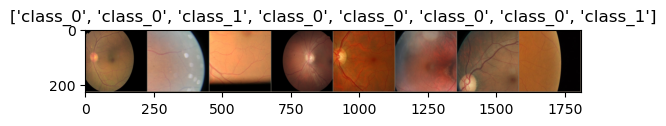

time: 961 ms (started: 2023-06-30 12:18:58 -05:00)


In [13]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [27]:
print(f"Image data type: {type(inputs)}")
print(f"Image size: {inputs.shape}")

Image data type: <class 'torch.Tensor'>
Image size: torch.Size([8, 3, 224, 224])
time: 981 µs (started: 2023-06-30 12:18:19 -05:00)


#### Transfer Learning Summary

- Use a pre-trained model out-of-the-box (good if a model already exists for your problem).

- Use a pre-trained model as a “feature extractor” (good if you want to adapt a pre-trained model for a specific problem).

- Fine-tune a pre-trained model (same as 2 but generally yields better results, although at more computational cost).

### Training the model

Now, let"s write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.

### Visualizing the model predictions

Generic function to display predictions for a few images




Generic function to display accuracy, and loss for train, and valididation data

## Fine Tuning

Load a pretrained model and reset final fully connected layer.

In [28]:
run = neptune.init_run(
    project="edwin.alvarez/Kaggle-GC",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIwZjM0NzgxNy1lMDI1LTQxMzgtYTE2NS03OTIwOWY5NzgwNTkifQ==",
)  # your credentials

parameters = {
    "model_name": model_name,
    "num_classes": num_classes,
    "batch_size": batch_size,
    "num_epochs": num_epochs
}
run["parameters"] = parameters
run["option/name"] = "fine tuning"

/tmp/ipykernel_131203/914562867.py:1: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  run = neptune.init_run(


KeyboardInterrupt: 

time: 6.19 s (started: 2023-06-30 12:18:19 -05:00)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

model_ft, input_size = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=True)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss() # nn.BCELoss() # nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

run["optim/name"] = "Adam"
run["optim/lr"] = 0.001

time: 361 ms (started: 2023-06-29 18:41:59 -05:00)


### Train and evaluation

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.


In [ ]:
model_ft, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model_ft, criterion, optimizer_ft,
                                                                                        exp_lr_scheduler, num_epochs=num_epochs)

Epoch 1/25
----------
train Loss: 0.5635 Acc: 0.7415
val Loss: 0.5547 Acc: 0.7275

Epoch 2/25
----------
train Loss: 0.5429 Acc: 0.7528
val Loss: 0.5273 Acc: 0.7562

Epoch 3/25
----------
train Loss: 0.5329 Acc: 0.7592
val Loss: 0.5265 Acc: 0.7625

Epoch 4/25
----------
train Loss: 0.5284 Acc: 0.7615
val Loss: 0.5336 Acc: 0.7562

Epoch 5/25
----------
train Loss: 0.5258 Acc: 0.7600
val Loss: 0.5118 Acc: 0.7662

Epoch 6/25
----------
train Loss: 0.5235 Acc: 0.7652
val Loss: 0.5191 Acc: 0.7623

Epoch 7/25
----------
train Loss: 0.5236 Acc: 0.7636
val Loss: 0.5339 Acc: 0.7534

Epoch 8/25
----------
train Loss: 0.5141 Acc: 0.7682
val Loss: 0.5242 Acc: 0.7595

Epoch 9/25
----------
train Loss: 0.5132 Acc: 0.7692
val Loss: 0.5311 Acc: 0.7576

Epoch 10/25
----------
train Loss: 0.5105 Acc: 0.7702
val Loss: 0.5150 Acc: 0.7641

Epoch 11/25
----------
train Loss: 0.5138 Acc: 0.7696
val Loss: 0.5308 Acc: 0.7580

Epoch 12/25
----------
train Loss: 0.5107 Acc: 0.7725
val Loss: 0.5343 Acc: 0.7548

E

In [ ]:
# show_results(train_losses, valid_losses, train_accuracies, valid_accuracies)

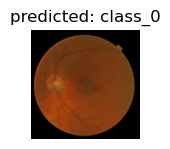

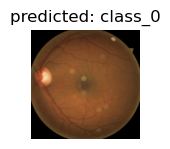

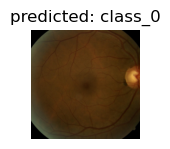

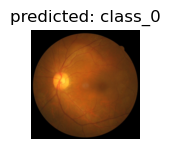

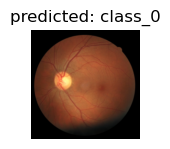

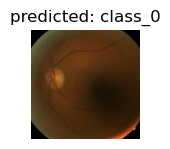

time: 961 ms (started: 2023-06-29 16:59:13 -05:00)


In [ ]:
visualize_model(model_ft, num_images=2)

## Feature extractor

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad = False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
[here](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward)_.




In [ ]:
run = neptune.init_run(
    project="edwin.alvarez/Kaggle-GC",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIwZjM0NzgxNy1lMDI1LTQxMzgtYTE2NS03OTIwOWY5NzgwNTkifQ==",
)  # your credentials

run["parameters"] = parameters
run["option/name"] = "feature extractor"

In [ ]:
# model_conv = torchvision.models.resnet18(pretrained=True)
model_conv, input_size = initialize_model(model_name, num_classes, feature_extract=True, use_pretrained=True)
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
# optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
optimizer_conv = optim.Adam(model_conv.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

run["optim/name"] = "Adam"
run["optim/lr"] = 0.001

time: 550 ms (started: 2023-06-29 19:29:59 -05:00)


### Train and evaluation

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don"t need to be computed for most of the
network. However, forward does need to be computed.


In [ ]:
model_conv, train_losses_, valid_losses_, train_accuracies_, valid_accuracies_ = train_model(model_conv, criterion, optimizer_conv,
                                                                                         exp_lr_scheduler, num_epochs=num_epochs)

Epoch 1/25
----------
train Loss: 0.5912 Acc: 0.7356
val Loss: 0.5993 Acc: 0.7188

Epoch 2/25
----------
train Loss: 0.5763 Acc: 0.7383
val Loss: 0.5953 Acc: 0.7188

Epoch 3/25
----------
train Loss: 0.5756 Acc: 0.7383
val Loss: 0.5962 Acc: 0.7188

Epoch 4/25
----------
train Loss: 0.5757 Acc: 0.7383
val Loss: 0.5965 Acc: 0.7188

Epoch 5/25
----------
train Loss: 0.5755 Acc: 0.7383
val Loss: 0.5948 Acc: 0.7188

Epoch 6/25
----------
train Loss: 0.5753 Acc: 0.7383
val Loss: 0.5953 Acc: 0.7188

Epoch 7/25
----------
train Loss: 0.5751 Acc: 0.7383
val Loss: 0.5947 Acc: 0.7188

Epoch 8/25
----------
train Loss: 0.5748 Acc: 0.7383
val Loss: 0.5949 Acc: 0.7188

Epoch 9/25
----------
train Loss: 0.5749 Acc: 0.7383
val Loss: 0.5949 Acc: 0.7188

Epoch 10/25
----------
train Loss: 0.5750 Acc: 0.7383
val Loss: 0.5950 Acc: 0.7188

Epoch 11/25
----------
train Loss: 0.5749 Acc: 0.7383
val Loss: 0.5950 Acc: 0.7188

Epoch 12/25
----------
train Loss: 0.5750 Acc: 0.7383
val Loss: 0.5950 Acc: 0.7188

E

In [ ]:
# show_results(train_losses_, valid_losses_, train_accuracies_, valid_accuracies_)

In [ ]:
visualize_model(model_conv, num_images=2)

plt.ioff()
plt.show()

## Experiments

In [14]:
# Top level data directory. Here we assume the format of the directory conforms
# to the ImageFolder structure
data_dir = "dataset"

# Models to choose from [resnet50, resnet152, alexnet, vgg19, squeezenet1_0, densenet201]
models_name = ["resnet50", "resnet152", "alexnet", "vgg19", "squeezenet1_0", "densenet201"]

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 12

# Number of epochs to train for
num_epochs = 20

# Flag for feature extracting. When False, we finetune the whole model,
# when True we only update the reshaped layer params
# feature_extract = True

input_size = 224

for option in [("fine tuning", False), ("feature extractor", True)]:
    for model_name in models_name:
        #---
        run = neptune.init_run(
            project="edwin.alvarez/KGC",
            api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIwZjM0NzgxNy1lMDI1LTQxMzgtYTE2NS03OTIwOWY5NzgwNTkifQ==",
        )  # your credentials

        run["sys/tags"].add(option[0])
        run["sys/tags"].add("transforms_0")

        parameters = {
            "model": model_name,
            "num_classes": num_classes,
            "num_epochs": num_epochs,
            "batch_size": batch_size,
            "criterion": "CrossEntropyLoss",
            "optimazer": "Adam",
            "lr": 0.001
        }
        run["params"] = parameters

        #---
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        device

        model, input_size = initialize_model(model_name, num_classes, feature_extract=option[1], use_pretrained=True)
        model = model.to(device)

        criterion = nn.CrossEntropyLoss() # nn.BCELoss() # nn.CrossEntropyLoss()

        # Observe that all parameters are being optimized
        # optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Decay LR by a factor of 0.1 every 7 epochs
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

        #---
        model, \
        train_losses, \
        valid_losses, \
        train_accuracies, \
        valid_accuracies = train_model(run, model, device, dataloaders, dataset_sizes, 
                                       criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)
        # validations
        for data in ["train", "valid"]:
            labels, predictions, predictions_proba = get_predictions(model, dataloaders, data)
            auc = roc_auc_score(labels, predictions_proba[:, 1])
            run["{}/auc".format(data)].append(auc)
        
        run.stop()

/tmp/ipykernel_131515/1672605304.py:26: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  run = neptune.init_run(


https://app.neptune.ai/edwin.alvarez/KGC/e/KGC-1
Invalidid model name, exiting...


Epoch: 19:  90%|█████████ | 18/20 [36:10<03:52, 116.19s/it, valid, Loss: 0.5949 Acc: 0.7188]

## Comparasion

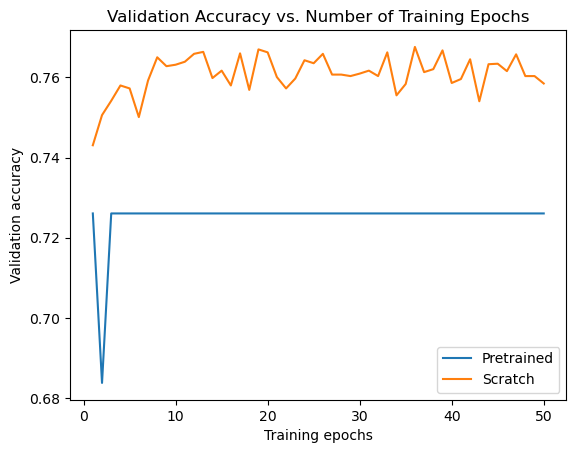

In [ ]:
# Plot the training curves of valididation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in valid_accuracies]
shist = [h.cpu().numpy() for h in valid_accuracies_]

plt.title("valididation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training epochs")
plt.ylabel("valididation accuracy")
plt.plot(range(1, num_epochs+1), ohist, label="Pretrained")
plt.plot(range(1, num_epochs+1), shist, label="Scratch")
# plt.ylim((0,1.))
# plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
# plt.grid()
plt.show()

## View metrics to train and valididation

In [ ]:
labels, predictions, predictions_proba = get_predictions(model_ft, dataloaders, data="train"):

In [ ]:
print(classification_report(labels, predictions, digits=4))

              precision    recall  f1-score   support

           0     0.7261    1.0000    0.8413      5892
           1     0.0000    0.0000    0.0000      2223

    accuracy                         0.7261      8115
   macro avg     0.3630    0.5000    0.4206      8115
weighted avg     0.5272    0.7261    0.6108      8115



/home/ealvarez/miniconda3/envs/kaggle_3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ealvarez/miniconda3/envs/kaggle_3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ealvarez/miniconda3/envs/kaggle_3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [ ]:
roc_auc_score(labels, predictions_proba[:, 1])

0.5438692307997699

## Prepared test data to Kaggle

#### Read test image

In [ ]:
df_test = pd.read_csv("source/sample.csv")
df_test

,ID,score
0,c74d97b01eae257e44aa9d5bade97baf_left,0
1,c74d97b01eae257e44aa9d5bade97baf_right,0
2,70efdf2ec9b086079795c442636b55fb_left,0
3,70efdf2ec9b086079795c442636b55fb_right,0
4,1f0e3dad99908345f7439f8ffabdffc4_left,0
...,...,...
10533,e261790d3a4cb0c69c17d7c183830289_right,0
10534,d21137447f7fdc47f7e6677ae35522a7_left,0
10535,d21137447f7fdc47f7e6677ae35522a7_right,0
10536,ec2951e5afb60d72a4a3e0be6d3e9c0a_left,0


In [ ]:
# Copy images to test folder
""" for index, row in df_test.iterrows():
    # print(row["File_names"], row["Target"])
    s = "source/X-Ray-Pneumonia-Images/Images/{}".format(row["File_names"])
    t = "x_rays_data/test/".format(group, row["File_names"])
    shutil.copy(s, t) """

time: 10.5 s (started: 2022-10-24 00:40:09 -05:00)


#### Get proba (option 1)

In [ ]:
test_transformations = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

time: 1.67 ms (started: 2022-10-24 18:25:17 -05:00)


In [ ]:
def get_predict_proba(df_image_path, labels_dict, final_model):
  y_prob = list()
  for index, row in df_image_path.iterrows():
    path = "source/X-Ray-Pneumonia-Images/Images/" + row["File_names"]
    img = Image.open(path).convert("RGB")

    with torch.no_grad():
      # Preprocesamos la imagen
      x = test_transformations(img)
      x = x[None] #(224, 224, 3) -> (1, 224, 224, 3)

      x = x.to(device).to(torch.float32)
      # Get prediction
      outputs = final_model(x)

      y = torch.nn.functional.softmax(outputs, dim=-1)
      # print(y[0])
      # print(y.cpu().numpy()[0])
      y_prob.append(y)

  y_prob = torch.cat(y_prob, dim=0)
  return y_prob

time: 1.84 ms (started: 2022-10-24 18:25:21 -05:00)


In [ ]:
y_prob = get_predict_proba(df_test, {}, model_ft)
y_prob

tensor([[1.5601e-02, 9.8440e-01],
        [1.0494e-01, 8.9506e-01],
        [9.8930e-01, 1.0702e-02],
        ...,
        [5.8417e-04, 9.9942e-01],
        [2.8505e-03, 9.9715e-01],
        [9.9165e-01, 8.3534e-03]], device='cuda:0')

time: 21.2 s (started: 2022-10-24 18:25:28 -05:00)


In [ ]:
y_prob_ = [h.cpu().numpy().tolist() for h in y_prob]
y_prob_ = np.array(y_prob_)[:,1]
# y_prob_

time: 28.4 ms (started: 2022-10-24 18:25:55 -05:00)


In [ ]:
# Create data frame for prob
data = {"Id": list(range(len(y_prob_))),
        "Predicted": y_prob_}

result = pd.DataFrame(data)
result.tail()

,Id,Predicted
874,874,0.002335
875,875,0.399763
876,876,0.999416
877,877,0.997150
878,878,0.008353


time: 13.3 ms (started: 2022-10-24 18:26:00 -05:00)


In [ ]:
# Save
from datetime import datetime

# datetime object containing current date and time
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y-%H:%M:%S")

result.to_csv("results/y_prob_z_{}.csv".format(dt_string), sep=",", index=False, header=True)

time: 51.3 ms (started: 2022-10-24 18:26:26 -05:00)


Get proba (option 2)

In [ ]:
data_transforms_ = {
    "test": test_transformations,
}

image_datasets_ = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms_[x])
                  for x in ["test"]}
dataloaders_ = {x: torch.utils.data.DataLoader(image_datasets_[x], batch_size=batch_size,
                                               shuffle=False, num_workers=4)
              for x in ["test"]}

time: 9.54 ms (started: 2022-10-24 13:58:59 -05:00)


In [ ]:
data_transforms_ = {
    "test": test_transformations,
}

image_datasets_ = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                           data_transforms_[x])
                  for x in ["test"]}

shuffled_dataset = torch.utils.data.Subset(image_datasets_["test"], torch.randperm(len(image_datasets_["test"])).tolist())

dataloaders_ = {x: torch.utils.data.DataLoader(shuffled_dataset, batch_size=batch_size,
                                               shuffle=False, num_workers=1)
              for x in ["test"]}

time: 11.2 ms (started: 2022-10-24 14:10:50 -05:00)


In [ ]:
predictions_proba = list()

with torch.no_grad():
  for batch_x_test, batch_y_test in dataloaders_["test"]:
    batch_x_test = batch_x_test.to(device).to(torch.float32)
    batch_y_test = batch_y_test.to(device).to(torch.int64)

    batch_test_predictions = model_ft(batch_x_test)
    # batch_test_predictions = model_conv(batch_x_test)

    batch_test_predictions = torch.nn.functional.softmax(batch_test_predictions, dim=-1)
    predictions_proba.append(batch_test_predictions)
    # print(batch_test_predictions)

    labels.append(batch_y_test)
    predictions.append(batch_test_predictions)

predictions_proba = torch.cat(predictions_proba, dim=0)

time: 11.6 s (started: 2022-10-24 14:10:56 -05:00)


In [ ]:
predictions_proba

tensor([[0.0019, 0.9981],
        [0.0022, 0.9978],
        [0.7550, 0.2450],
        ...,
        [0.5107, 0.4893],
        [0.7598, 0.2402],
        [0.0129, 0.9871]], device='cuda:0')

time: 8.41 ms (started: 2022-10-24 14:11:16 -05:00)


## Further Learning

If you would like to learn more about the applications of transfer learning,
checkout our [Quantized Transfer Learning for Computer Vision Tutorial](https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html).





In [ ]:
len(y_prob), len(predictions_proba)

(879, 879)

time: 4.42 ms (started: 2022-10-24 14:11:26 -05:00)


In [ ]:
a = 0
b = 0
for k, item in enumerate(predictions_proba):
  if item in y_prob:
    a += 1
  else:
    b += 1

print(a, b)

635 244
time: 50.6 ms (started: 2022-10-24 14:11:29 -05:00)


In [ ]:
predictions_proba - y_prob

tensor([[-0.1453,  0.1453],
        [-0.2138,  0.2138],
        [-0.1328,  0.1328],
        ...,
        [ 0.4921, -0.4921],
        [ 0.7417, -0.7417],
        [-0.6879,  0.6879]], device='cuda:0')

time: 6.92 ms (started: 2022-10-24 14:11:34 -05:00)


In [ ]:
ohist = []
shist = []

ohist = [h.cpu().numpy().tolist() for h in y_prob]
shist = [h.cpu().numpy().tolist() for h in predictions_proba]

time: 47.2 ms (started: 2022-10-24 14:11:39 -05:00)


In [ ]:
ohist[:10]

[[0.14711539447307587, 0.8528845906257629],
 [0.21607042849063873, 0.7839295864105225],
 [0.8877939581871033, 0.11220604926347733],
 [0.01686420850455761, 0.9831357598304749],
 [0.002497079549357295, 0.9975029826164246],
 [0.9482443928718567, 0.051755599677562714],
 [0.9887135028839111, 0.01128657441586256],
 [0.24072377383708954, 0.7592762112617493],
 [0.0020917770452797413, 0.9979082345962524],
 [0.0027087603230029345, 0.9972912669181824]]

time: 4.9 ms (started: 2022-10-24 13:46:39 -05:00)


In [ ]:
shist[:10]

[[0.984623908996582, 0.015376050025224686],
 [0.1200985312461853, 0.8799015283584595],
 [0.5861233472824097, 0.41387665271759033],
 [7.99512563389726e-05, 0.9999200105667114],
 [0.0014523343415930867, 0.9985476136207581],
 [0.00046254004701040685, 0.999537467956543],
 [0.9405980706214905, 0.05940190330147743],
 [0.7390910983085632, 0.26090890169143677],
 [0.9634218215942383, 0.036578238010406494],
 [0.004561557900160551, 0.9954385161399841]]

time: 4.82 ms (started: 2022-10-24 13:46:43 -05:00)


In [ ]:
a = np.array(ohist)
b = np.array(shist)

time: 1.97 ms (started: 2022-10-24 14:11:44 -05:00)


In [ ]:
a_b = a - b
a_b

array([[ 0.14525925, -0.14525932],
       [ 0.21383996, -0.21384001],
       [ 0.13283145, -0.13283143],
       ...,
       [-0.49212154,  0.49212158],
       [-0.74168267,  0.7416826 ],
       [ 0.68785605, -0.68785617]])

time: 5.83 ms (started: 2022-10-24 14:11:48 -05:00)


In [ ]:
a_ = a[a[:, 1].argsort()]
a_

array([[9.96677041e-01, 3.32291843e-03],
       [9.93342698e-01, 6.65730750e-03],
       [9.91753936e-01, 8.24605953e-03],
       ...,
       [5.45697039e-05, 9.99945402e-01],
       [5.34961218e-05, 9.99946475e-01],
       [5.62726700e-06, 9.99994397e-01]])

time: 5.43 ms (started: 2022-10-24 14:11:53 -05:00)


In [ ]:
b_ = b[b[:, 1].argsort()]
b_

array([[9.96677041e-01, 3.32291843e-03],
       [9.93342698e-01, 6.65730750e-03],
       [9.91753936e-01, 8.24605953e-03],
       ...,
       [5.45698058e-05, 9.99945402e-01],
       [5.34960709e-05, 9.99946475e-01],
       [5.62726700e-06, 9.99994397e-01]])

time: 11.2 ms (started: 2022-10-24 14:11:57 -05:00)


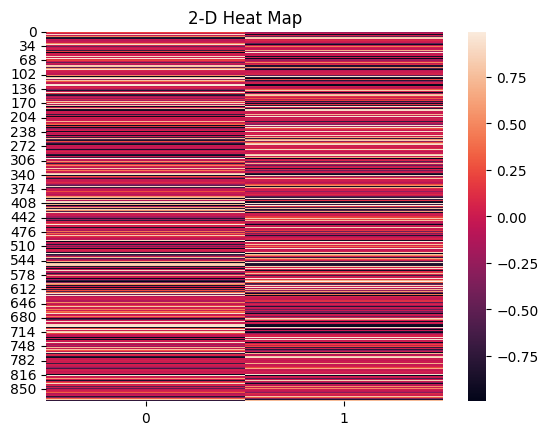

time: 308 ms (started: 2022-10-24 14:12:05 -05:00)


In [ ]:
# Program to plot 2-D Heat map
# using seaborn.heatmap() method
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

sns.heatmap(a_b, annot=False)

plt.title( "2-D Heat Map" )
plt.show()

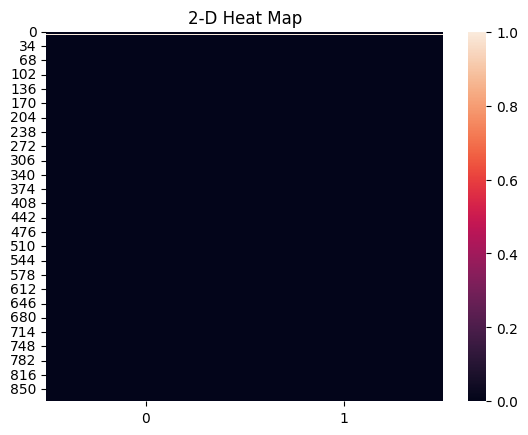

time: 241 ms (started: 2022-10-24 14:12:18 -05:00)


In [ ]:
sns.heatmap(a_b_, annot=False)

plt.title( "2-D Heat Map" )
plt.show()

In [ ]:
a = 0
b = 0
for k, item in enumerate(shist):
  if item in ohist:
    a += 1
  else:
    b += 1

print(a, b)

167 712
time: 27.1 ms (started: 2022-10-24 13:12:41 -05:00)
